# The Convolutional Classifier
Create your first computer vision model with Keras.


# 👁️‍🗨️ Welcome to Computer Vision!

Have you ever wanted to teach a computer to **see**?  
Well, we’re going to do exactly that — together.

---

## 🚀 What We’ll Learn

🎯 Build an image classifier using **Keras**  
🧱 Design our own **convnet** with modular blocks  
🔍 Understand how neural nets **extract visual features**  
⚡ Boost our models using **transfer learning**  
🧬 Use **data augmentation** to grow our dataset  

We already explored the *Introduction to Deep Learning* course, so we’re more than ready to dive in.

Let’s get started!

---

## 📚 Introduction

In this course, we’re stepping into the exciting world of **computer vision**.

Our mission?  
To build a neural network that can “understand” an image the same way our eyes and brain do.

We’ll focus on a classic problem:  
> Can we teach a computer to recognize what’s in a picture?

Think about plant recognition apps 🌿 or dog-breed detectors 🐶 — those are image classifiers.  
By the end of this course, we’ll be building models just as capable.

And while we’ll focus on image classification, what we learn will help us go further — into **GANs**, **object detection**, and **image segmentation** later on.

---

## 🧠 The Convolutional Classifier

A convolutional neural network (CNN or *convnet*) we use for classification has two main parts:

1. 🧱 **The base** — this extracts features from the image  
2. 🧠 **The head** — this classifies the image based on those features

### 🧩 What’s a “feature”?

It might be:
- A line or edge
- A color patch
- A texture or shape
- A combination of patterns

The base helps our network learn to see those, and the head uses that information to figure out what’s in the image.

---

## 🛠️ Training the Classifier

During training, our model learns two essential things:

1. **What features to extract** (the job of the base)  
2. **How to map those features to labels** (the head’s role)

> These days, we rarely start from scratch.

Instead, we usually borrow a **pretrained base** (like ResNet or VGG), and **add our own head** on top.  
This way, we’re using a model that already knows how to “see” — and just teaching it to “name” the things we care about.

That’s called:

### 🔄 Transfer Learning

Transfer learning helps us:
- Train faster
- Use less data
- Get better results

And that’s exactly what we’ll be doing.

---

## 🧪 Summary

| Concept               | What It Means                                                 |
|------------------------|---------------------------------------------------------------|
| 📦 Convnet             | A neural net built for visual data                            |
| 🧱 Base                | Convolution layers to extract features                         |
| 🧠 Head                | Dense layers to classify features                              |
| 📸 Image Classification| Figuring out what's in a picture                              |
| 🔁 Transfer Learning   | Reuse a trained base and customize the top                     |
| 🧬 Data Augmentation   | Expand our dataset by flipping, rotating, zooming, etc.       |

---

We’re about to build some amazing things — and by the end, we’ll have a solid foundation in computer vision and the tools to keep exploring more.

Let’s jump in!
```


In [2]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'c:/Users/samad/OneDrive/Dokumenty/526546846848/Computer_Vision/car-or-truck/versions/1/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'c:/Users/samad/OneDrive/Dokumenty/526546846848/Computer_Vision/car-or-truck/versions/1/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


The InceptionV1 model pretrained on ImageNet is available in the TensorFlow Hub repository, but we'll load it from a local copy. 

# 1) Define Pretrained Base & Attach Head #


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Path to your model
model_path = r'c:\Users\samad\OneDrive\Dokumenty\526546846848\Computer_Vision\cv-course-models\versions\4\cv-course-models\inceptionv1'

# Create a wrapper class for the SavedModel
class SavedModelWrapper(keras.layers.Layer):
    def __init__(self, model_path):
        super(SavedModelWrapper, self).__init__()
        self.model = tf.saved_model.load(model_path)
        self.infer = self.model.signatures['serving_default']
        
        # Get input details
        self.input_shapes = list(self.infer.structured_input_signature[1].values())[0].shape
        self.input_name = list(self.infer.structured_input_signature[1].keys())[0]
        
    def call(self, inputs):
        # Get output tensor from the SavedModel
        results = self.infer(**{self.input_name: inputs})
        
        # Return the first output (adjust as needed based on model outputs)
        return list(results.values())[0]

# Create Sequential model with the wrapper
inception_wrapper = SavedModelWrapper(model_path)
inception_wrapper.trainable = False # Freeze the model bcse we are loading a pre-trained model
model = keras.Sequential([
    # Input layer with the correct shape
    layers.InputLayer(input_shape=(128, 128, 3)),
    
    # SavedModel wrapper
    inception_wrapper,
    
    # Your additional layers
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



# 2) Train #

Before training a model in Keras, you need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a **binary classification** problem: `Car` coded as 0, and `Truck` coded as 1.

In [7]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [8]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 613ms/step - binary_accuracy: 0.7041 - loss: 0.5519 - val_binary_accuracy: 0.8238 - val_loss: 0.3994
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 667ms/step - binary_accuracy: 0.8309 - loss: 0.3841 - val_binary_accuracy: 0.8369 - val_loss: 0.3758
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 826ms/step - binary_accuracy: 0.8426 - loss: 0.3571 - val_binary_accuracy: 0.8404 - val_loss: 0.3653
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 973ms/step - binary_accuracy: 0.8565 - loss: 0.3404 - val_binary_accuracy: 0.8448 - val_loss: 0.3587
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 72s 912ms/step - binary_accuracy: 0.8633 - loss: 0.3278 - val_binary_accuracy: 0.8472 - val_loss: 0.3544
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 944ms/step - binary_accuracy: 0.8688 - loss: 0.3175 - val_binary_accuracy: 0.8481 - val_loss: 0.3516
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - binary_accuracy: 0.8734 - loss: 0.3088 - val_binary_accuracy: 0.8481 - val_loss: 0.3497
Ep

<Axes: >

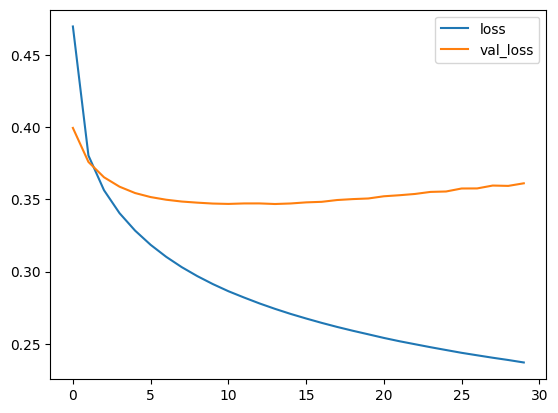

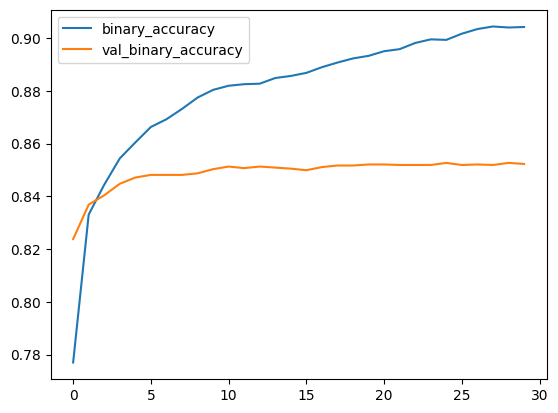

In [9]:
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

--->>> Overfitting!!